In [35]:
import pandas as pd
import yaml
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [36]:
from modules.data import Data
from modules.search import Search
from modules.video import Video
from modules.analyze import Analyze

In [37]:
data_obj = Data()
analyze_obj = Analyze()

In [38]:
df_video_labeled = pd.read_csv("unique_id_map/videos_anonymized.csv", dtype={"author_channel_number": object, "video_number": object})
df_comments = pd.read_csv("unique_id_map/comments_anonymized.csv", dtype={"video_number": object, "comment_thread_number": object, "comment_number": object, "author_channel_url_number": object})

In [39]:
# Display duration in a readable format
df_video_labeled["video_duration"] = df_video_labeled["video_duration"].apply(analyze_obj.get_duration_in_seconds)
df_video_labeled.head()
# Get engagement metrics
df_video_labeled["likes_to_dislikes"] = df_video_labeled.apply(lambda row: analyze_obj.likes_to_dislikes(row["like_count"], row["dislike_count"]), axis=1)
df_video_labeled["dislikes_to_likes"] = df_video_labeled.apply(lambda row: analyze_obj.dislikes_to_likes(row["dislike_count"], row["like_count"]), axis=1)
df_video_labeled["engagement_score"] = df_video_labeled.apply(lambda row: analyze_obj.engagement_score(row["like_count"], row["dislike_count"], row["comment_count"], row["view_count"]), axis=1)
# Get unique commenters for every video
df_comments_unique_commenters = df_comments.groupby("video_number")[["comment_number"]].nunique().reset_index().rename(columns={"comment_number": "num_unique_commenters"})
df_video_labeled = pd.merge(left=df_video_labeled, right=df_comments_unique_commenters, how="left", on="video_number", validate="one_to_one", suffixes=("", "_DROP")).filter(regex="^(?!.*_DROP)")
# Factor in for videos without any comments
df_video_labeled["num_unique_commenters"].fillna(0, inplace=True)

In [40]:
dict_variables = data_obj.load_yaml("variables.yaml")
list_category = dict_variables["category"]
list_theme = dict_variables["theme"]

In [41]:
# Get dataframes per category and label
list_df_video_category, list_df_video_theme = analyze_obj.splice_by_labels(df_video_labeled, list_category, list_theme)

In [42]:
display(list_df_video_category[0].head())

,video_title,video_description,view_count,like_count,dislike_count,favorite_count,comment_count,publish_time,video_duration,author_channel_url_number,video_number,category,theme,likes_to_dislikes,dislikes_to_likes,engagement_score,num_unique_commenters
31,Redwood City School District To Install Vape D...,The Redwood City School District Board of Trus...,1105372,24119,1104,0,4137,2019-09-26T06:21:35Z,110,7225,00005,Protective,News report,21846.920290,45.773042,26.561194,105.0
40,Vaping / E-Cigarette Associated Lung Injury: C...,An important update on E-Cigarette / Vaping pr...,17800,459,10,0,100,2019-11-19T20:47:35Z,304,22161,00012,Protective,Harmful health consequences,45900.000000,21.786492,31.966292,78.0
41,"Vaping / E-Cigarette Lung Failure, Illness, Di...",Please see our most recent update to vaping as...,147156,1335,422,0,828,2019-09-19T18:12:16Z,600,22161,00320,Protective,Harmful health consequences,3163.507109,316.104869,17.566392,174.0
43,The dangers of vaping CBD oil,"Dr. Cass Ingram, author of ""The Hemp Oil Mirac...",39012,285,421,0,144,2019-10-21T16:51:44Z,241,19710,00014,Protective,"Harmful health consequences, News report",676.959620,1477.192982,21.788168,150.0
44,Vaping vs. Smoking,What are the effects of smoking in the lungs? ...,471,5,3,0,1,2019-08-27T00:20:31Z,146,8883,00015,Protective,"Harmful health consequences, Comparative healt...",1666.666667,600.000000,19.108280,1.0


## Stats on views
Descriptive statistics on view count per label

,category,count,mean,std,median
0,Protective,132,8.415775e+05,3.478989e+06,46437.5
1,Risky,276,1.492521e+06,4.123480e+06,148152.5
2,Neutral,43,5.698636e+05,1.644923e+06,87154.0
3,Potential misinformed claims,5,1.631372e+05,9.440142e+04,203830.0


,theme,count,mean,std,median
0,Vaping tricks,102,2.972450e+06,6.252307e+06,652430.5
1,Marketing,135,3.542647e+05,7.795443e+05,91488.0
2,Harmful health consequences,150,7.757108e+05,3.277054e+06,47379.0
3,Promotion/Celebration,27,1.965180e+06,2.740716e+06,612535.0
4,Comparative health effects with smoking,91,1.045678e+06,4.185862e+06,33146.0
5,News report,47,6.001753e+05,1.638318e+06,56047.0
6,N.A.,15,3.093649e+05,7.285282e+05,51524.0


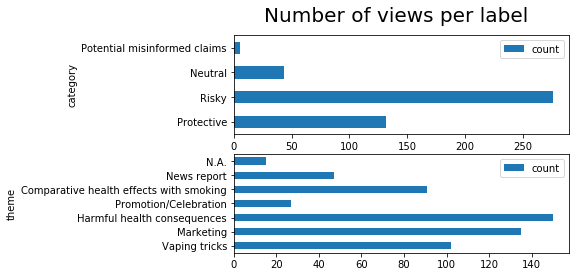

In [43]:
df_view_count_category_describe = analyze_obj.describe_df(list_df=list_df_video_category, label_name="category", list_label=list_category, column="view_count")
display(df_view_count_category_describe)
df_view_count_theme_describe = analyze_obj.describe_df(list_df=list_df_video_theme, label_name="theme", list_label=list_theme, column="view_count")
display(df_view_count_theme_describe)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Number of views per label", fontsize=20)
df_view_count_category_describe.plot.barh(x="category", y="count", ax=axes[0])
df_view_count_theme_describe.plot.barh(x="theme", y="count", ax=axes[1])

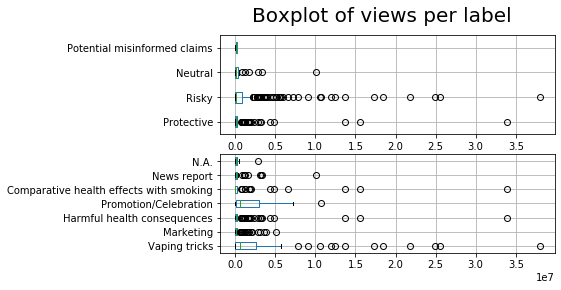

In [44]:
list_view_count_category = [list_df_video_category[index]["view_count"] for index, _ in enumerate(list_category)]
df_view_count_category_boxplot = pd.concat(list_view_count_category, axis=1, keys=list_category)

list_view_count_theme = [list_df_video_theme[index]["view_count"] for index, _ in enumerate(list_theme)]
df_view_count_theme_boxplot = pd.concat(list_view_count_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Boxplot of views per label", fontsize=20)
df_view_count_category_boxplot.boxplot(column=list_category, ax=axes[0], vert=False)
df_view_count_theme_boxplot.boxplot(column=list_theme, ax=axes[1], vert=False)

## Stats on duration
Descriptive statistics on video duration per label

In [45]:
df_video_duration_category_describe = analyze_obj.describe_df(list_df=list_df_video_category, label_name="category", list_label=list_category, column="video_duration", is_count=False)
display(df_video_duration_category_describe)
df_video_duration_theme_describe = analyze_obj.describe_df(list_df=list_df_video_theme, label_name="theme", list_label=list_theme, column="video_duration", is_count=False)
display(df_video_duration_theme_describe)

,category,mean,std,median
0,Protective,568.469697,818.485433,283.5
1,Risky,387.420290,256.083333,325.0
2,Neutral,423.232558,407.279057,303.0
3,Potential misinformed claims,584.400000,344.558123,644.0


,theme,mean,std,median
0,Vaping tricks,307.990196,178.662384,242.0
1,Marketing,452.829630,278.239603,401.0
2,Harmful health consequences,552.100000,775.215828,290.5
3,Promotion/Celebration,375.962963,282.919325,294.0
4,Comparative health effects with smoking,481.582418,649.459691,260.0
5,News report,341.553191,361.091028,241.0
6,N.A.,465.600000,459.109511,396.0


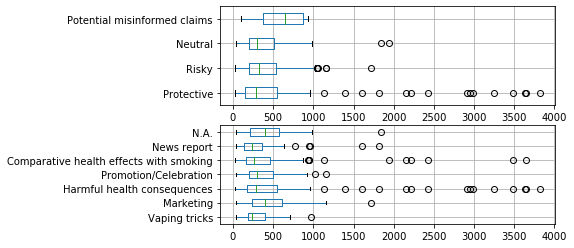

In [46]:
list_video_duration_category = [list_df_video_category[index]["video_duration"] for index, _ in enumerate(list_category)]
df_video_duration_category = pd.concat(list_video_duration_category, axis=1, keys=list_category)

list_video_duration_theme = [list_df_video_theme[index]["video_duration"] for index, _ in enumerate(list_theme)]
df_video_duration_theme = pd.concat(list_video_duration_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
df_video_duration_category.boxplot(column=list_category, ax=axes[0], vert=False)
df_video_duration_theme.boxplot(column=list_theme, ax=axes[1], vert=False)

## Stats on engagement
There are three metrics on display here:
1. Likes to dislikes ratio: likes/dislikes * 1000
2. Dislikes to likes ratio: dislikes/likes * 1000
3. Engagement score: (likes + dislikes + comment_count)/view_count * 1000

Likes to dislikes
Dislikes to likes
Engagement score


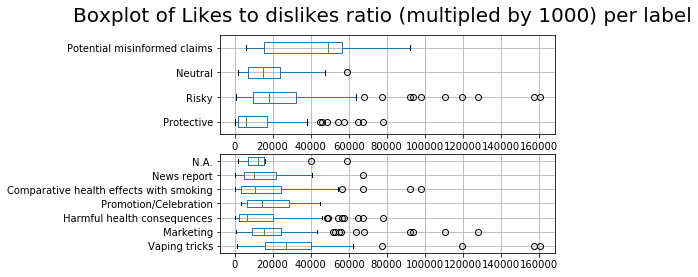

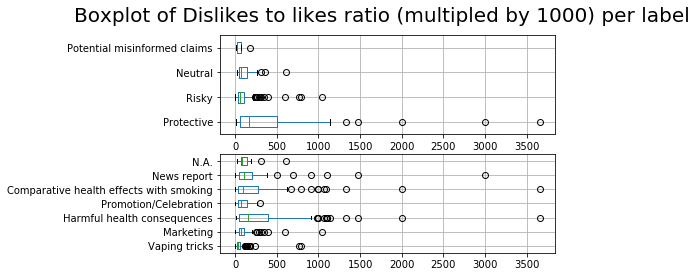

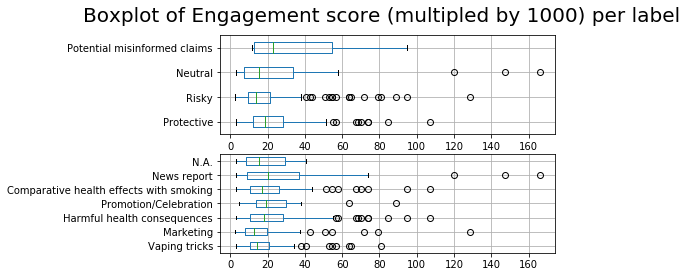

In [47]:
list_df_video_category_likes_dislikes = [
    list_df_video_category[index][
        (list_df_video_category[index]["comment_count"] > 0) &
        (list_df_video_category[index]["like_count"] > 0)
    ]
    for index in range(len(list_category))
]
list_df_video_theme_likes_dislikes = [
    list_df_video_theme[index][
        (list_df_video_theme[index]["comment_count"] > 0) &
        (list_df_video_theme[index]["like_count"] > 0)
    ]
    for index in range(len(list_theme))
]

# Likes to dislikes
print("Likes to dislikes")
list_likes_to_dislikes_category = [list_df_video_category_likes_dislikes[index]["likes_to_dislikes"] for index, _ in enumerate(list_category)]
df_likes_to_dislikes_category = pd.concat(list_likes_to_dislikes_category, axis=1, keys=list_category)

list_likes_to_dislikes_theme = [list_df_video_theme_likes_dislikes[index]["likes_to_dislikes"] for index, _ in enumerate(list_theme)]
df_likes_to_dislikes_theme = pd.concat(list_likes_to_dislikes_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Boxplot of Likes to dislikes ratio (multipled by 1000) per label", fontsize=20)
df_likes_to_dislikes_category.boxplot(column=list_category, ax=axes[0], vert=False)
df_likes_to_dislikes_theme.boxplot(column=list_theme, ax=axes[1], vert=False)

# Dislikes to likes
print("Dislikes to likes")

list_dislikes_to_likes_category = [list_df_video_category_likes_dislikes[index]["dislikes_to_likes"] for index, _ in enumerate(list_category)]
df_dislikes_to_likes_category = pd.concat(list_dislikes_to_likes_category, axis=1, keys=list_category)

list_dislikes_to_likes_theme = [list_df_video_theme_likes_dislikes[index]["dislikes_to_likes"] for index, _ in enumerate(list_theme)]
df_dislikes_to_likes_theme = pd.concat(list_dislikes_to_likes_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Boxplot of Dislikes to likes ratio (multipled by 1000) per label", fontsize=20)
df_dislikes_to_likes_category.boxplot(column=list_category, ax=axes[0], vert=False)
df_dislikes_to_likes_theme.boxplot(column=list_theme, ax=axes[1], vert=False)

# Engagement score
print("Engagement score")

list_engagement_score_category = [list_df_video_category_likes_dislikes[index]["engagement_score"] for index, _ in enumerate(list_category)]
df_engagement_score_category = pd.concat(list_engagement_score_category, axis=1, keys=list_category)

list_engagement_score_theme = [list_df_video_theme_likes_dislikes[index]["engagement_score"] for index, _ in enumerate(list_theme)]
df_engagement_score_theme = pd.concat(list_engagement_score_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Boxplot of Engagement score (multipled by 1000) per label", fontsize=20)
df_engagement_score_category.boxplot(column=list_category, ax=axes[0], vert=False)
df_engagement_score_theme.boxplot(column=list_theme, ax=axes[1], vert=False)

## Stats on comments
Descriptive statistics on comments per label

Stats on comment_count


,category,count,mean,std,median
0,Protective,102,2115.970588,5875.416703,154.0
1,Risky,262,1072.805344,2841.606047,150.5
2,Neutral,38,1260.105263,2659.967718,206.5
3,Potential misinformed claims,5,643.000000,676.753279,198.0


,theme,count,mean,std,median
0,Vaping tricks,100,1364.920000,2868.253700,304.5
1,Marketing,125,286.656000,816.601238,96.0
2,Harmful health consequences,117,1887.094017,5511.675762,162.0
3,Promotion/Celebration,27,3405.629630,5657.203387,694.0
4,Comparative health effects with smoking,79,1871.544304,5853.748862,138.0
5,News report,38,1559.763158,3101.954732,145.0
6,N.A.,13,613.076923,1248.652504,120.0


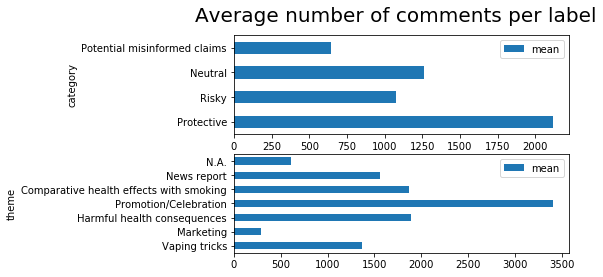

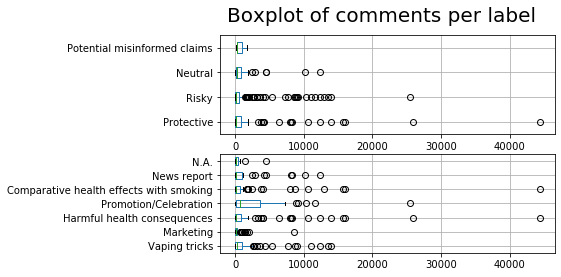

In [48]:
list_df_video_category_comments = [
    list_df_video_category[index][
        list_df_video_category[index]["comment_count"] > 0
    ]
    for index in range(len(list_category))
]
list_df_video_theme_comments = [
    list_df_video_theme[index][
        list_df_video_theme[index]["comment_count"] > 0
    ]
    for index in range(len(list_theme))
]

print("Stats on comment_count")

df_comment_count_category_describe = analyze_obj.describe_df(list_df=list_df_video_category_comments, label_name="category", list_label=list_category, column="comment_count")
display(df_comment_count_category_describe)
df_comment_count_theme_describe = analyze_obj.describe_df(list_df=list_df_video_theme_comments, label_name="theme", list_label=list_theme, column="comment_count")
display(df_comment_count_theme_describe)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Average number of comments per label", fontsize=20)
df_comment_count_category_describe.plot.barh(x="category", y="mean", ax=axes[0])
df_comment_count_theme_describe.plot.barh(x="theme", y="mean", ax=axes[1])

list_comment_count_category = [list_df_video_category_comments[index]["comment_count"] for index, _ in enumerate(list_category)]
df_comment_count_category_boxplot = pd.concat(list_comment_count_category, axis=1, keys=list_category)

list_comment_count_theme = [list_df_video_theme_comments[index]["comment_count"] for index, _ in enumerate(list_theme)]
df_comment_count_theme_boxplot = pd.concat(list_comment_count_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Boxplot of comments per label", fontsize=20)
df_comment_count_category_boxplot.boxplot(column=list_category, ax=axes[0], vert=False)
df_comment_count_theme_boxplot.boxplot(column=list_theme, ax=axes[1], vert=False)

Stats on unique commenters


,category,count,mean,std,median
0,Protective,102,83.333333,53.711981,101.5
1,Risky,262,87.797710,55.178786,102.5
2,Neutral,38,88.368421,52.083831,109.0
3,Potential misinformed claims,5,128.600000,22.478879,115.0


,theme,count,mean,std,median
0,Vaping tricks,100,79.460000,49.823207,102.0
1,Marketing,125,89.400000,57.286631,98.0
2,Harmful health consequences,117,84.461538,53.243348,103.0
3,Promotion/Celebration,27,108.592593,59.609150,106.0
4,Comparative health effects with smoking,79,79.025316,53.275764,105.0
5,News report,38,83.789474,51.929348,102.5
6,N.A.,13,75.307692,56.426035,106.0


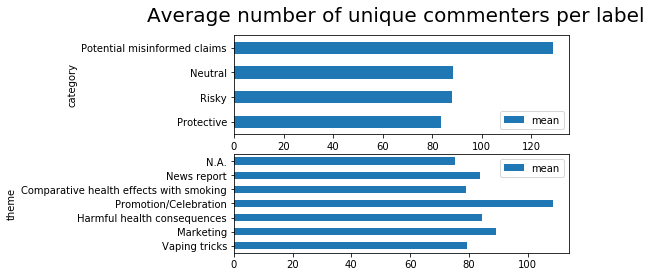

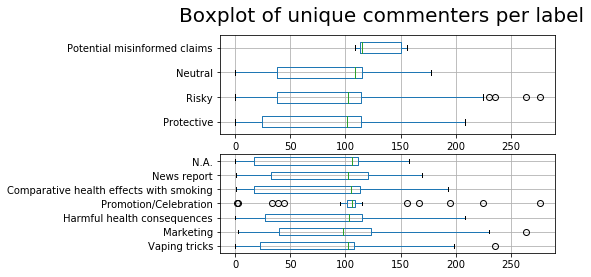

In [49]:
print("Stats on unique commenters")

df_num_unique_commenters_category_describe = analyze_obj.describe_df(list_df=list_df_video_category_comments, label_name="category", list_label=list_category, column="num_unique_commenters")
display(df_num_unique_commenters_category_describe)
df_num_unique_commenters_theme_describe = analyze_obj.describe_df(list_df=list_df_video_theme_comments, label_name="theme", list_label=list_theme, column="num_unique_commenters")
display(df_num_unique_commenters_theme_describe)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Average number of unique commenters per label", fontsize=20)
df_num_unique_commenters_category_describe.plot.barh(x="category", y="mean", ax=axes[0])
df_num_unique_commenters_theme_describe.plot.barh(x="theme", y="mean", ax=axes[1])

list_num_unique_commenters_category = [list_df_video_category_comments[index]["num_unique_commenters"] for index, _ in enumerate(list_category)]
df_num_unique_commenters_category_boxplot = pd.concat(list_num_unique_commenters_category, axis=1, keys=list_category)

list_num_unique_commenters_theme = [list_df_video_theme_comments[index]["num_unique_commenters"] for index, _ in enumerate(list_theme)]
df_num_unique_commenters_theme_boxplot = pd.concat(list_num_unique_commenters_theme, axis=1, keys=list_theme)

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Boxplot of unique commenters per label", fontsize=20)
df_num_unique_commenters_category_boxplot.boxplot(column=list_category, ax=axes[0], vert=False)
df_num_unique_commenters_theme_boxplot.boxplot(column=list_theme, ax=axes[1], vert=False)

## Stats on videos
Descriptive statistics on videos
What could be added:
> Time taken for a comment to be posted after a video is uploaded.

In [55]:
# list_df_video_category_comments_merged = [
#     pd.merge(left=list_df_video_category_comments[index], right=df_comments, on="video_number", validate="one_to_many", suffixes=("", "_X"))
#     for index in range(len(list_category))
# ]
# list_df_video_theme_comments_merged = [
#     pd.merge(left=list_df_video_theme_comments[index], right=df_comments, on="video_number", validate="one_to_many", suffixes=("", "_X"))
#     for index in range(len(list_theme))
# ]
# print("Time taken to start commenting")
# list_df_video_category_comments_merged[0].head()

